In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 32

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalAvgPool1D()(output) for output in layer_outputs[-3:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 32)    192         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 32)    0           conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPoo

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 32)    192         input_3[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 32)    0           conv1d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 5333, 32)     0           activation_7[0][0]               
__________________________________________________________________________________________________
conv1d_8 (

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 32)    192         input_5[0][0]                    
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 32)    0           conv1d_18[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_18 (MaxPooling1D) (None, 5333, 32)     0           activation_18[0][0]              
__________________________________________________________________________________________________
conv1d_19 

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7384 - acc: 0.0852
Epoch 00001: val_loss improved from inf to 2.70404, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_checkpoint/001-2.7040.hdf5
36805/36805 [==============================] - 19s 509us/sample - loss: 2.7384 - acc: 0.0852 - val_loss: 2.7040 - val_acc: 0.1281
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6816 - acc: 0.1322
Epoch 00002: val_loss improved from 2.70404 to 2.62643, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_checkpoint/002-2.6264.hdf5
36805/36805 [==============================] - 17s 450us/sample - loss: 2.6816 - acc: 0.1322 - val_loss: 2.6264 - val_acc: 0.1973
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5963 - acc: 0.1683
Epoch 00003: val_loss improved from 2.62643

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9073 - acc: 0.3726
Epoch 00022: val_loss improved from 1.75851 to 1.74609, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_checkpoint/022-1.7461.hdf5
36805/36805 [==============================] - 16s 437us/sample - loss: 1.9073 - acc: 0.3726 - val_loss: 1.7461 - val_acc: 0.4785
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9008 - acc: 0.3770
Epoch 00023: val_loss improved from 1.74609 to 1.73276, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_checkpoint/023-1.7328.hdf5
36805/36805 [==============================] - 16s 440us/sample - loss: 1.9007 - acc: 0.3770 - val_loss: 1.7328 - val_acc: 0.4819
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8817 - acc: 0.3807
Epoch 00024: val_loss improved from 1.73276 to 1.71696, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_ch

Epoch 44/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7150 - acc: 0.4462
Epoch 00044: val_loss improved from 1.52053 to 1.51065, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_checkpoint/044-1.5107.hdf5
36805/36805 [==============================] - 16s 442us/sample - loss: 1.7149 - acc: 0.4463 - val_loss: 1.5107 - val_acc: 0.5565
Epoch 45/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7048 - acc: 0.4446
Epoch 00045: val_loss improved from 1.51065 to 1.50360, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_checkpoint/045-1.5036.hdf5
36805/36805 [==============================] - 16s 446us/sample - loss: 1.7049 - acc: 0.4446 - val_loss: 1.5036 - val_acc: 0.5528
Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7000 - acc: 0.4489
Epoch 00046: val_loss improved from 1.50360 to 1.49435, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_ch

Epoch 66/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5954 - acc: 0.4849
Epoch 00066: val_loss did not improve from 1.36911
36805/36805 [==============================] - 16s 440us/sample - loss: 1.5954 - acc: 0.4850 - val_loss: 1.3693 - val_acc: 0.5998
Epoch 67/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5865 - acc: 0.4902
Epoch 00067: val_loss improved from 1.36911 to 1.35642, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_checkpoint/067-1.3564.hdf5
36805/36805 [==============================] - 16s 440us/sample - loss: 1.5864 - acc: 0.4902 - val_loss: 1.3564 - val_acc: 0.6031
Epoch 68/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5807 - acc: 0.4893
Epoch 00068: val_loss did not improve from 1.35642
36805/36805 [==============================] - 16s 438us/sample - loss: 1.5806 - acc: 0.4893 - val_loss: 1.3618 - val_acc: 0.6000
Epoch 69/500
36800/36805 [============================>.] -

Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5091 - acc: 0.5146
Epoch 00089: val_loss improved from 1.26744 to 1.26393, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_checkpoint/089-1.2639.hdf5
36805/36805 [==============================] - 16s 439us/sample - loss: 1.5091 - acc: 0.5146 - val_loss: 1.2639 - val_acc: 0.6382
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5007 - acc: 0.5206
Epoch 00090: val_loss improved from 1.26393 to 1.25789, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_checkpoint/090-1.2579.hdf5
36805/36805 [==============================] - 16s 439us/sample - loss: 1.5007 - acc: 0.5206 - val_loss: 1.2579 - val_acc: 0.6420
Epoch 91/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5021 - acc: 0.5209
Epoch 00091: val_loss improved from 1.25789 to 1.25653, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_ch

Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4508 - acc: 0.5354
Epoch 00112: val_loss did not improve from 1.18951
36805/36805 [==============================] - 16s 437us/sample - loss: 1.4508 - acc: 0.5354 - val_loss: 1.1932 - val_acc: 0.6627
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4491 - acc: 0.5368
Epoch 00113: val_loss improved from 1.18951 to 1.18907, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_checkpoint/113-1.1891.hdf5
36805/36805 [==============================] - 16s 440us/sample - loss: 1.4490 - acc: 0.5368 - val_loss: 1.1891 - val_acc: 0.6580
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4478 - acc: 0.5374
Epoch 00114: val_loss improved from 1.18907 to 1.18774, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_checkpoint/114-1.1877.hdf5
36805/36805 [==============================] - 16s 434us/sample - loss: 1.4478 

Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3983 - acc: 0.5564
Epoch 00136: val_loss improved from 1.13812 to 1.13537, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_checkpoint/136-1.1354.hdf5
36805/36805 [==============================] - 16s 440us/sample - loss: 1.3982 - acc: 0.5564 - val_loss: 1.1354 - val_acc: 0.6783
Epoch 137/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.4009 - acc: 0.5567
Epoch 00137: val_loss improved from 1.13537 to 1.13414, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_checkpoint/137-1.1341.hdf5
36805/36805 [==============================] - 16s 434us/sample - loss: 1.4011 - acc: 0.5568 - val_loss: 1.1341 - val_acc: 0.6767
Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3960 - acc: 0.5552
Epoch 00138: val_loss improved from 1.13414 to 1.13254, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv

Epoch 159/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3629 - acc: 0.5684
Epoch 00159: val_loss improved from 1.09003 to 1.08918, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_checkpoint/159-1.0892.hdf5
36805/36805 [==============================] - 16s 433us/sample - loss: 1.3628 - acc: 0.5684 - val_loss: 1.0892 - val_acc: 0.6900
Epoch 160/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3583 - acc: 0.5707
Epoch 00160: val_loss improved from 1.08918 to 1.08415, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_checkpoint/160-1.0841.hdf5
36805/36805 [==============================] - 16s 434us/sample - loss: 1.3582 - acc: 0.5707 - val_loss: 1.0841 - val_acc: 0.6946
Epoch 161/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3554 - acc: 0.5724
Epoch 00161: val_loss did not improve from 1.08415
36805/36805 [==============================] - 16s 434us/sample - loss: 1.3554 

Epoch 183/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3199 - acc: 0.5847
Epoch 00183: val_loss did not improve from 1.04229
36805/36805 [==============================] - 16s 433us/sample - loss: 1.3199 - acc: 0.5847 - val_loss: 1.0437 - val_acc: 0.7042
Epoch 184/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3186 - acc: 0.5861
Epoch 00184: val_loss did not improve from 1.04229
36805/36805 [==============================] - 16s 432us/sample - loss: 1.3186 - acc: 0.5860 - val_loss: 1.0465 - val_acc: 0.7060
Epoch 185/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3183 - acc: 0.5858
Epoch 00185: val_loss did not improve from 1.04229
36805/36805 [==============================] - 16s 433us/sample - loss: 1.3182 - acc: 0.5857 - val_loss: 1.0446 - val_acc: 0.7072
Epoch 186/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3105 - acc: 0.5868
Epoch 00186: val_loss improved from 1.04229 to 1.03554, saving mo

Epoch 208/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2803 - acc: 0.5996
Epoch 00208: val_loss improved from 1.00908 to 1.00529, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_checkpoint/208-1.0053.hdf5
36805/36805 [==============================] - 16s 439us/sample - loss: 1.2803 - acc: 0.5995 - val_loss: 1.0053 - val_acc: 0.7142
Epoch 209/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2851 - acc: 0.5987
Epoch 00209: val_loss did not improve from 1.00529
36805/36805 [==============================] - 16s 440us/sample - loss: 1.2852 - acc: 0.5987 - val_loss: 1.0059 - val_acc: 0.7154
Epoch 210/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2820 - acc: 0.5981
Epoch 00210: val_loss did not improve from 1.00529
36805/36805 [==============================] - 16s 438us/sample - loss: 1.2820 - acc: 0.5982 - val_loss: 1.0073 - val_acc: 0.7177
Epoch 211/500
36800/36805 [============================>

Epoch 234/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2633 - acc: 0.6044
Epoch 00234: val_loss did not improve from 0.97800
36805/36805 [==============================] - 16s 436us/sample - loss: 1.2632 - acc: 0.6045 - val_loss: 0.9789 - val_acc: 0.7235
Epoch 235/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2582 - acc: 0.6048
Epoch 00235: val_loss did not improve from 0.97800
36805/36805 [==============================] - 16s 437us/sample - loss: 1.2582 - acc: 0.6048 - val_loss: 0.9793 - val_acc: 0.7235
Epoch 236/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2521 - acc: 0.6066
Epoch 00236: val_loss improved from 0.97800 to 0.97453, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_checkpoint/236-0.9745.hdf5
36805/36805 [==============================] - 16s 438us/sample - loss: 1.2521 - acc: 0.6066 - val_loss: 0.9745 - val_acc: 0.7270
Epoch 237/500
36800/36805 [============================>

Epoch 260/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2352 - acc: 0.6141
Epoch 00260: val_loss improved from 0.95424 to 0.95163, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_checkpoint/260-0.9516.hdf5
36805/36805 [==============================] - 16s 440us/sample - loss: 1.2353 - acc: 0.6141 - val_loss: 0.9516 - val_acc: 0.7333
Epoch 261/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2348 - acc: 0.6148
Epoch 00261: val_loss did not improve from 0.95163
36805/36805 [==============================] - 16s 436us/sample - loss: 1.2347 - acc: 0.6148 - val_loss: 0.9526 - val_acc: 0.7340
Epoch 262/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2389 - acc: 0.6132
Epoch 00262: val_loss did not improve from 0.95163
36805/36805 [==============================] - 16s 435us/sample - loss: 1.2390 - acc: 0.6132 - val_loss: 0.9526 - val_acc: 0.7340
Epoch 263/500
36736/36805 [============================>

36736/36805 [============================>.] - ETA: 0s - loss: 1.2194 - acc: 0.6198
Epoch 00286: val_loss did not improve from 0.93729
36805/36805 [==============================] - 16s 435us/sample - loss: 1.2196 - acc: 0.6198 - val_loss: 0.9401 - val_acc: 0.7391
Epoch 287/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2310 - acc: 0.6176
Epoch 00287: val_loss did not improve from 0.93729
36805/36805 [==============================] - 16s 435us/sample - loss: 1.2311 - acc: 0.6176 - val_loss: 0.9442 - val_acc: 0.7310
Epoch 288/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2197 - acc: 0.6214
Epoch 00288: val_loss improved from 0.93729 to 0.93154, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_checkpoint/288-0.9315.hdf5
36805/36805 [==============================] - 16s 443us/sample - loss: 1.2197 - acc: 0.6213 - val_loss: 0.9315 - val_acc: 0.7375
Epoch 289/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 1.2101 - acc: 0.6243
Epoch 00312: val_loss did not improve from 0.91893
36805/36805 [==============================] - 16s 435us/sample - loss: 1.2102 - acc: 0.6243 - val_loss: 0.9297 - val_acc: 0.7417
Epoch 313/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2069 - acc: 0.6242
Epoch 00313: val_loss did not improve from 0.91893
36805/36805 [==============================] - 16s 436us/sample - loss: 1.2069 - acc: 0.6242 - val_loss: 0.9213 - val_acc: 0.7421
Epoch 314/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2060 - acc: 0.6246
Epoch 00314: val_loss did not improve from 0.91893
36805/36805 [==============================] - 16s 437us/sample - loss: 1.2061 - acc: 0.6245 - val_loss: 0.9191 - val_acc: 0.7428
Epoch 315/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2069 - acc: 0.6230
Epoch 00315: val_loss did not improve from 0.91893
36805/36805 [===============

Epoch 338/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1939 - acc: 0.6279
Epoch 00338: val_loss did not improve from 0.90800
36805/36805 [==============================] - 16s 439us/sample - loss: 1.1940 - acc: 0.6279 - val_loss: 0.9126 - val_acc: 0.7412
Epoch 339/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1936 - acc: 0.6268
Epoch 00339: val_loss improved from 0.90800 to 0.90710, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_checkpoint/339-0.9071.hdf5
36805/36805 [==============================] - 16s 439us/sample - loss: 1.1935 - acc: 0.6269 - val_loss: 0.9071 - val_acc: 0.7442
Epoch 340/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1963 - acc: 0.6260
Epoch 00340: val_loss did not improve from 0.90710
36805/36805 [==============================] - 16s 435us/sample - loss: 1.1963 - acc: 0.6260 - val_loss: 0.9083 - val_acc: 0.7421
Epoch 341/500
36800/36805 [============================>

Epoch 364/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1878 - acc: 0.6300
Epoch 00364: val_loss did not improve from 0.89549
36805/36805 [==============================] - 16s 436us/sample - loss: 1.1877 - acc: 0.6300 - val_loss: 0.9025 - val_acc: 0.7466
Epoch 365/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1860 - acc: 0.6324
Epoch 00365: val_loss did not improve from 0.89549
36805/36805 [==============================] - 16s 435us/sample - loss: 1.1862 - acc: 0.6323 - val_loss: 0.9035 - val_acc: 0.7447
Epoch 366/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1894 - acc: 0.6301
Epoch 00366: val_loss did not improve from 0.89549
36805/36805 [==============================] - 16s 437us/sample - loss: 1.1894 - acc: 0.6301 - val_loss: 0.8963 - val_acc: 0.7461
Epoch 367/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1907 - acc: 0.6310
Epoch 00367: val_loss improved from 0.89549 to 0.89346, saving mo

36800/36805 [============================>.] - ETA: 0s - loss: 1.1749 - acc: 0.6358
Epoch 00391: val_loss did not improve from 0.88704
36805/36805 [==============================] - 16s 433us/sample - loss: 1.1748 - acc: 0.6359 - val_loss: 0.8887 - val_acc: 0.7529
Epoch 392/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1872 - acc: 0.6324
Epoch 00392: val_loss did not improve from 0.88704
36805/36805 [==============================] - 16s 438us/sample - loss: 1.1872 - acc: 0.6324 - val_loss: 0.8892 - val_acc: 0.7524
Epoch 393/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1833 - acc: 0.6348
Epoch 00393: val_loss improved from 0.88704 to 0.88670, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_checkpoint/393-0.8867.hdf5
36805/36805 [==============================] - 16s 438us/sample - loss: 1.1834 - acc: 0.6347 - val_loss: 0.8867 - val_acc: 0.7480
Epoch 394/500
36736/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 1.1794 - acc: 0.6352
Epoch 00418: val_loss did not improve from 0.87698
36805/36805 [==============================] - 16s 437us/sample - loss: 1.1794 - acc: 0.6352 - val_loss: 0.8833 - val_acc: 0.7531
Epoch 419/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1705 - acc: 0.6372
Epoch 00419: val_loss did not improve from 0.87698
36805/36805 [==============================] - 16s 436us/sample - loss: 1.1704 - acc: 0.6373 - val_loss: 0.8783 - val_acc: 0.7554
Epoch 420/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1758 - acc: 0.6359
Epoch 00420: val_loss did not improve from 0.87698
36805/36805 [==============================] - 16s 439us/sample - loss: 1.1758 - acc: 0.6359 - val_loss: 0.8774 - val_acc: 0.7531
Epoch 421/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1655 - acc: 0.6370
Epoch 00421: val_loss improved from 0.87698 to 0.87270, saving model to model/c

Epoch 446/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1604 - acc: 0.6405
Epoch 00446: val_loss did not improve from 0.87216
36805/36805 [==============================] - 16s 434us/sample - loss: 1.1602 - acc: 0.6405 - val_loss: 0.8738 - val_acc: 0.7596
Epoch 447/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1687 - acc: 0.6378
Epoch 00447: val_loss improved from 0.87216 to 0.87146, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_checkpoint/447-0.8715.hdf5
36805/36805 [==============================] - 16s 437us/sample - loss: 1.1682 - acc: 0.6378 - val_loss: 0.8715 - val_acc: 0.7549
Epoch 448/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1577 - acc: 0.6395
Epoch 00448: val_loss improved from 0.87146 to 0.87069, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_checkpoint/448-0.8707.hdf5
36805/36805 [==============================] - 16s 436us/sample - loss: 1.1576 

36800/36805 [============================>.] - ETA: 0s - loss: 1.1574 - acc: 0.6414
Epoch 00472: val_loss improved from 0.86261 to 0.86261, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_checkpoint/472-0.8626.hdf5
36805/36805 [==============================] - 16s 438us/sample - loss: 1.1574 - acc: 0.6415 - val_loss: 0.8626 - val_acc: 0.7633
Epoch 473/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1510 - acc: 0.6426
Epoch 00473: val_loss did not improve from 0.86261
36805/36805 [==============================] - 16s 434us/sample - loss: 1.1509 - acc: 0.6426 - val_loss: 0.8652 - val_acc: 0.7601
Epoch 474/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1507 - acc: 0.6408
Epoch 00474: val_loss did not improve from 0.86261
36805/36805 [==============================] - 16s 437us/sample - loss: 1.1508 - acc: 0.6408 - val_loss: 0.8651 - val_acc: 0.7596
Epoch 475/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 1.1446 - acc: 0.6433
Epoch 00499: val_loss improved from 0.85450 to 0.85400, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv_checkpoint/499-0.8540.hdf5
36805/36805 [==============================] - 16s 438us/sample - loss: 1.1447 - acc: 0.6433 - val_loss: 0.8540 - val_acc: 0.7598
Epoch 500/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1541 - acc: 0.6415
Epoch 00500: val_loss did not improve from 0.85400
36805/36805 [==============================] - 16s 443us/sample - loss: 1.1541 - acc: 0.6415 - val_loss: 0.8600 - val_acc: 0.7608

1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv Model


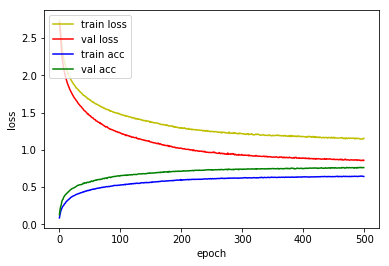

4815/4815 [==============================] - 1s 219us/sample - loss: 0.9031 - acc: 0.7360
Loss: 0.9030666095321671 Accuracy: 0.7360332

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7368 - acc: 0.0840
Epoch 00001: val_loss improved from inf to 2.69050, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_4_conv_checkpoint/001-2.6905.hdf5
36805/36805 [==============================] - 18s 484us/sample - loss: 2.7368 - acc: 0.0840 - val_loss: 2.6905 - val_acc: 0.1148
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6400 - acc: 0.1338
Epoch 00002: val_loss improved from 2.69050 to 2.49261, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_4_conv_checkpoint/002-2.4926.hdf5
36805/36805 [==============================] - 16s 445us/sample - loss: 2.6400 - acc: 0.1338 - val_loss: 2.4926 - val_acc: 0.2455
Epoch 3/500
36800/36805 [==========================

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6414 - acc: 0.4610
Epoch 00022: val_loss improved from 1.43209 to 1.41135, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_4_conv_checkpoint/022-1.4113.hdf5
36805/36805 [==============================] - 16s 446us/sample - loss: 1.6414 - acc: 0.4610 - val_loss: 1.4113 - val_acc: 0.5805
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6260 - acc: 0.4671
Epoch 00023: val_loss improved from 1.41135 to 1.38756, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_4_conv_checkpoint/023-1.3876.hdf5
36805/36805 [==============================] - 16s 443us/sample - loss: 1.6259 - acc: 0.4672 - val_loss: 1.3876 - val_acc: 0.5917
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6095 - acc: 0.4780
Epoch 00024: val_loss improved from 1.38756 to 1.37861, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_4_conv_ch

Epoch 44/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3864 - acc: 0.5567
Epoch 00044: val_loss improved from 1.14675 to 1.14322, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_4_conv_checkpoint/044-1.1432.hdf5
36805/36805 [==============================] - 16s 447us/sample - loss: 1.3863 - acc: 0.5568 - val_loss: 1.1432 - val_acc: 0.6636
Epoch 45/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3828 - acc: 0.5598
Epoch 00045: val_loss improved from 1.14322 to 1.13590, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_4_conv_checkpoint/045-1.1359.hdf5
36805/36805 [==============================] - 16s 442us/sample - loss: 1.3828 - acc: 0.5598 - val_loss: 1.1359 - val_acc: 0.6725
Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3730 - acc: 0.5629
Epoch 00046: val_loss improved from 1.13590 to 1.13097, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_4_conv_ch

Epoch 67/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2597 - acc: 0.6018
Epoch 00067: val_loss did not improve from 1.01274
36805/36805 [==============================] - 16s 446us/sample - loss: 1.2596 - acc: 0.6018 - val_loss: 1.0148 - val_acc: 0.7065
Epoch 68/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2459 - acc: 0.6071
Epoch 00068: val_loss did not improve from 1.01274
36805/36805 [==============================] - 17s 449us/sample - loss: 1.2458 - acc: 0.6071 - val_loss: 1.0145 - val_acc: 0.7053
Epoch 69/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2544 - acc: 0.6034
Epoch 00069: val_loss improved from 1.01274 to 0.99650, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_4_conv_checkpoint/069-0.9965.hdf5
36805/36805 [==============================] - 16s 448us/sample - loss: 1.2544 - acc: 0.6034 - val_loss: 0.9965 - val_acc: 0.7095
Epoch 70/500
36800/36805 [============================>.] -

Epoch 92/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1821 - acc: 0.6323
Epoch 00092: val_loss improved from 0.93853 to 0.93612, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_4_conv_checkpoint/092-0.9361.hdf5
36805/36805 [==============================] - 16s 447us/sample - loss: 1.1822 - acc: 0.6323 - val_loss: 0.9361 - val_acc: 0.7256
Epoch 93/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1811 - acc: 0.6293
Epoch 00093: val_loss did not improve from 0.93612
36805/36805 [==============================] - 16s 445us/sample - loss: 1.1810 - acc: 0.6293 - val_loss: 0.9394 - val_acc: 0.7240
Epoch 94/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1731 - acc: 0.6323
Epoch 00094: val_loss improved from 0.93612 to 0.93248, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_4_conv_checkpoint/094-0.9325.hdf5
36805/36805 [==============================] - 16s 443us/sample - loss: 1.1732 - a

36800/36805 [============================>.] - ETA: 0s - loss: 1.1268 - acc: 0.6452
Epoch 00117: val_loss improved from 0.88274 to 0.88120, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_4_conv_checkpoint/117-0.8812.hdf5
36805/36805 [==============================] - 16s 448us/sample - loss: 1.1267 - acc: 0.6453 - val_loss: 0.8812 - val_acc: 0.7396
Epoch 118/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1260 - acc: 0.6538
Epoch 00118: val_loss did not improve from 0.88120
36805/36805 [==============================] - 16s 448us/sample - loss: 1.1260 - acc: 0.6538 - val_loss: 0.8817 - val_acc: 0.7452
Epoch 119/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1305 - acc: 0.6468
Epoch 00119: val_loss did not improve from 0.88120
36805/36805 [==============================] - 16s 447us/sample - loss: 1.1305 - acc: 0.6467 - val_loss: 0.8871 - val_acc: 0.7419
Epoch 120/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 1.0890 - acc: 0.6618
Epoch 00142: val_loss did not improve from 0.84517
36805/36805 [==============================] - 16s 444us/sample - loss: 1.0890 - acc: 0.6618 - val_loss: 0.8486 - val_acc: 0.7526
Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0899 - acc: 0.6637
Epoch 00143: val_loss did not improve from 0.84517
36805/36805 [==============================] - 16s 443us/sample - loss: 1.0899 - acc: 0.6637 - val_loss: 0.8454 - val_acc: 0.7512
Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0923 - acc: 0.6627
Epoch 00144: val_loss improved from 0.84517 to 0.84318, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_4_conv_checkpoint/144-0.8432.hdf5
36805/36805 [==============================] - 16s 442us/sample - loss: 1.0924 - acc: 0.6627 - val_loss: 0.8432 - val_acc: 0.7515
Epoch 145/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 1.0558 - acc: 0.6708
Epoch 00167: val_loss did not improve from 0.81095
36805/36805 [==============================] - 16s 438us/sample - loss: 1.0557 - acc: 0.6709 - val_loss: 0.8116 - val_acc: 0.7594
Epoch 168/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0624 - acc: 0.6703
Epoch 00168: val_loss improved from 0.81095 to 0.80620, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_4_conv_checkpoint/168-0.8062.hdf5
36805/36805 [==============================] - 16s 438us/sample - loss: 1.0624 - acc: 0.6704 - val_loss: 0.8062 - val_acc: 0.7652
Epoch 169/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0522 - acc: 0.6749
Epoch 00169: val_loss did not improve from 0.80620
36805/36805 [==============================] - 16s 443us/sample - loss: 1.0523 - acc: 0.6748 - val_loss: 0.8093 - val_acc: 0.7624
Epoch 170/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 1.0400 - acc: 0.6818
Epoch 00192: val_loss did not improve from 0.78057
36805/36805 [==============================] - 16s 446us/sample - loss: 1.0399 - acc: 0.6819 - val_loss: 0.7830 - val_acc: 0.7713
Epoch 193/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0262 - acc: 0.6833
Epoch 00193: val_loss improved from 0.78057 to 0.77832, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_4_conv_checkpoint/193-0.7783.hdf5
36805/36805 [==============================] - 16s 448us/sample - loss: 1.0262 - acc: 0.6833 - val_loss: 0.7783 - val_acc: 0.7757
Epoch 194/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0243 - acc: 0.6833
Epoch 00194: val_loss did not improve from 0.77832
36805/36805 [==============================] - 16s 445us/sample - loss: 1.0247 - acc: 0.6833 - val_loss: 0.7788 - val_acc: 0.7745
Epoch 195/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 1.0038 - acc: 0.6894
Epoch 00219: val_loss did not improve from 0.75486
36805/36805 [==============================] - 16s 445us/sample - loss: 1.0038 - acc: 0.6894 - val_loss: 0.7550 - val_acc: 0.7876
Epoch 220/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0060 - acc: 0.6906
Epoch 00220: val_loss did not improve from 0.75486
36805/36805 [==============================] - 16s 439us/sample - loss: 1.0060 - acc: 0.6906 - val_loss: 0.7584 - val_acc: 0.7836
Epoch 221/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0011 - acc: 0.6891
Epoch 00221: val_loss improved from 0.75486 to 0.74871, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_4_conv_checkpoint/221-0.7487.hdf5
36805/36805 [==============================] - 16s 436us/sample - loss: 1.0011 - acc: 0.6891 - val_loss: 0.7487 - val_acc: 0.7904
Epoch 222/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 0.9834 - acc: 0.6967
Epoch 00245: val_loss did not improve from 0.72887
36805/36805 [==============================] - 16s 446us/sample - loss: 0.9834 - acc: 0.6966 - val_loss: 0.7293 - val_acc: 0.7883
Epoch 246/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9910 - acc: 0.6960
Epoch 00246: val_loss did not improve from 0.72887
36805/36805 [==============================] - 16s 444us/sample - loss: 0.9912 - acc: 0.6959 - val_loss: 0.7331 - val_acc: 0.7973
Epoch 247/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9821 - acc: 0.6970
Epoch 00247: val_loss did not improve from 0.72887
36805/36805 [==============================] - 16s 442us/sample - loss: 0.9821 - acc: 0.6970 - val_loss: 0.7383 - val_acc: 0.7890
Epoch 248/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9770 - acc: 0.6998
Epoch 00248: val_loss improved from 0.72887 to 0.72750, saving model to model/c

Epoch 273/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9637 - acc: 0.7033
Epoch 00273: val_loss did not improve from 0.70380
36805/36805 [==============================] - 16s 443us/sample - loss: 0.9638 - acc: 0.7033 - val_loss: 0.7085 - val_acc: 0.8029
Epoch 274/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9611 - acc: 0.7040
Epoch 00274: val_loss did not improve from 0.70380
36805/36805 [==============================] - 16s 441us/sample - loss: 0.9611 - acc: 0.7040 - val_loss: 0.7048 - val_acc: 0.8064
Epoch 275/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9643 - acc: 0.7039
Epoch 00275: val_loss did not improve from 0.70380
36805/36805 [==============================] - 16s 439us/sample - loss: 0.9642 - acc: 0.7040 - val_loss: 0.7053 - val_acc: 0.8069
Epoch 276/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9591 - acc: 0.7042
Epoch 00276: val_loss did not improve from 0.70380
36805/36805 [=

Epoch 301/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9407 - acc: 0.7105
Epoch 00301: val_loss improved from 0.68949 to 0.68930, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_4_conv_checkpoint/301-0.6893.hdf5
36805/36805 [==============================] - 16s 447us/sample - loss: 0.9407 - acc: 0.7105 - val_loss: 0.6893 - val_acc: 0.8109
Epoch 302/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9395 - acc: 0.7122
Epoch 00302: val_loss improved from 0.68930 to 0.68887, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_4_conv_checkpoint/302-0.6889.hdf5
36805/36805 [==============================] - 16s 447us/sample - loss: 0.9395 - acc: 0.7122 - val_loss: 0.6889 - val_acc: 0.8111
Epoch 303/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9408 - acc: 0.7109
Epoch 00303: val_loss improved from 0.68887 to 0.68705, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_4_conv

36800/36805 [============================>.] - ETA: 0s - loss: 0.9350 - acc: 0.7119
Epoch 00326: val_loss did not improve from 0.66842
36805/36805 [==============================] - 16s 446us/sample - loss: 0.9350 - acc: 0.7119 - val_loss: 0.6757 - val_acc: 0.8153
Epoch 327/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9312 - acc: 0.7169
Epoch 00327: val_loss did not improve from 0.66842
36805/36805 [==============================] - 16s 445us/sample - loss: 0.9313 - acc: 0.7169 - val_loss: 0.6712 - val_acc: 0.8157
Epoch 328/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9260 - acc: 0.7150
Epoch 00328: val_loss did not improve from 0.66842
36805/36805 [==============================] - 16s 445us/sample - loss: 0.9260 - acc: 0.7150 - val_loss: 0.6760 - val_acc: 0.8132
Epoch 329/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9269 - acc: 0.7174
Epoch 00329: val_loss did not improve from 0.66842
36805/36805 [===============

Epoch 354/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9062 - acc: 0.7221
Epoch 00354: val_loss did not improve from 0.65257
36805/36805 [==============================] - 16s 442us/sample - loss: 0.9062 - acc: 0.7220 - val_loss: 0.6579 - val_acc: 0.8218
Epoch 355/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9159 - acc: 0.7201
Epoch 00355: val_loss did not improve from 0.65257
36805/36805 [==============================] - 16s 444us/sample - loss: 0.9159 - acc: 0.7201 - val_loss: 0.6601 - val_acc: 0.8183
Epoch 356/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9179 - acc: 0.7181
Epoch 00356: val_loss improved from 0.65257 to 0.65051, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_4_conv_checkpoint/356-0.6505.hdf5
36805/36805 [==============================] - 16s 444us/sample - loss: 0.9178 - acc: 0.7181 - val_loss: 0.6505 - val_acc: 0.8234
Epoch 357/500
36800/36805 [============================>

Epoch 381/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9030 - acc: 0.7258
Epoch 00381: val_loss did not improve from 0.63918
36805/36805 [==============================] - 16s 445us/sample - loss: 0.9030 - acc: 0.7258 - val_loss: 0.6403 - val_acc: 0.8253
Epoch 382/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9005 - acc: 0.7246
Epoch 00382: val_loss did not improve from 0.63918
36805/36805 [==============================] - 16s 441us/sample - loss: 0.9006 - acc: 0.7245 - val_loss: 0.6445 - val_acc: 0.8246
Epoch 383/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9005 - acc: 0.7235
Epoch 00383: val_loss improved from 0.63918 to 0.63898, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_4_conv_checkpoint/383-0.6390.hdf5
36805/36805 [==============================] - 16s 443us/sample - loss: 0.9004 - acc: 0.7235 - val_loss: 0.6390 - val_acc: 0.8269
Epoch 384/500
36800/36805 [============================>

36800/36805 [============================>.] - ETA: 0s - loss: 0.8939 - acc: 0.7249
Epoch 00408: val_loss did not improve from 0.63069
36805/36805 [==============================] - 16s 439us/sample - loss: 0.8939 - acc: 0.7249 - val_loss: 0.6350 - val_acc: 0.8251
Epoch 409/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8864 - acc: 0.7290
Epoch 00409: val_loss did not improve from 0.63069
36805/36805 [==============================] - 16s 439us/sample - loss: 0.8864 - acc: 0.7291 - val_loss: 0.6310 - val_acc: 0.8293
Epoch 410/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8801 - acc: 0.7291
Epoch 00410: val_loss improved from 0.63069 to 0.62982, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_4_conv_checkpoint/410-0.6298.hdf5
36805/36805 [==============================] - 16s 442us/sample - loss: 0.8802 - acc: 0.7291 - val_loss: 0.6298 - val_acc: 0.8246
Epoch 411/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 435/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8757 - acc: 0.7335
Epoch 00435: val_loss did not improve from 0.61678
36805/36805 [==============================] - 16s 441us/sample - loss: 0.8757 - acc: 0.7335 - val_loss: 0.6245 - val_acc: 0.8339
Epoch 436/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8797 - acc: 0.7315
Epoch 00436: val_loss did not improve from 0.61678
36805/36805 [==============================] - 16s 440us/sample - loss: 0.8799 - acc: 0.7314 - val_loss: 0.6262 - val_acc: 0.8325
Epoch 437/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8767 - acc: 0.7346
Epoch 00437: val_loss did not improve from 0.61678
36805/36805 [==============================] - 16s 442us/sample - loss: 0.8767 - acc: 0.7347 - val_loss: 0.6171 - val_acc: 0.8304
Epoch 438/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8735 - acc: 0.7313
Epoch 00438: val_loss improved from 0.61678 to 0.61645, saving mo

36800/36805 [============================>.] - ETA: 0s - loss: 0.8639 - acc: 0.7353
Epoch 00463: val_loss improved from 0.61104 to 0.60946, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_4_conv_checkpoint/463-0.6095.hdf5
36805/36805 [==============================] - 16s 444us/sample - loss: 0.8640 - acc: 0.7353 - val_loss: 0.6095 - val_acc: 0.8351
Epoch 464/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8630 - acc: 0.7349
Epoch 00464: val_loss did not improve from 0.60946
36805/36805 [==============================] - 16s 441us/sample - loss: 0.8629 - acc: 0.7349 - val_loss: 0.6100 - val_acc: 0.8348
Epoch 465/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8607 - acc: 0.7365
Epoch 00465: val_loss did not improve from 0.60946
36805/36805 [==============================] - 16s 443us/sample - loss: 0.8606 - acc: 0.7365 - val_loss: 0.6184 - val_acc: 0.8302
Epoch 466/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 489/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8521 - acc: 0.7408
Epoch 00489: val_loss did not improve from 0.59649
36805/36805 [==============================] - 16s 442us/sample - loss: 0.8520 - acc: 0.7408 - val_loss: 0.6081 - val_acc: 0.8374
Epoch 490/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8607 - acc: 0.7396
Epoch 00490: val_loss did not improve from 0.59649
36805/36805 [==============================] - 16s 440us/sample - loss: 0.8607 - acc: 0.7396 - val_loss: 0.6122 - val_acc: 0.8365
Epoch 491/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8556 - acc: 0.7379
Epoch 00491: val_loss did not improve from 0.59649
36805/36805 [==============================] - 16s 439us/sample - loss: 0.8556 - acc: 0.7378 - val_loss: 0.5984 - val_acc: 0.8381
Epoch 492/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8541 - acc: 0.7373
Epoch 00492: val_loss did not improve from 0.59649
36805/36805 [=

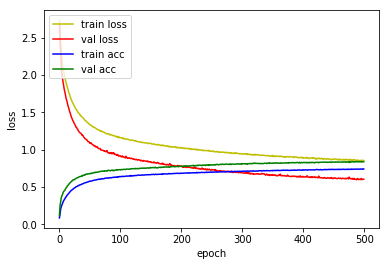

4815/4815 [==============================] - 1s 244us/sample - loss: 0.6589 - acc: 0.8064
Loss: 0.6589304419445224 Accuracy: 0.8064382

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7007 - acc: 0.1156
Epoch 00001: val_loss improved from inf to 2.54712, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_5_conv_checkpoint/001-2.5471.hdf5
36805/36805 [==============================] - 18s 501us/sample - loss: 2.7006 - acc: 0.1157 - val_loss: 2.5471 - val_acc: 0.2055
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4264 - acc: 0.2162
Epoch 00002: val_loss improved from 2.54712 to 2.18394, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_5_conv_checkpoint/002-2.1839.hdf5
36805/36805 [==============================] - 17s 450us/sample - loss: 2.4264 - acc: 0.2162 - val_loss: 2.1839 - val_acc: 0.3215
Epoch 3/500
36800/36805 [==========================

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3628 - acc: 0.5687
Epoch 00022: val_loss improved from 1.18493 to 1.17845, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_5_conv_checkpoint/022-1.1784.hdf5
36805/36805 [==============================] - 16s 446us/sample - loss: 1.3628 - acc: 0.5687 - val_loss: 1.1784 - val_acc: 0.6536
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3502 - acc: 0.5714
Epoch 00023: val_loss improved from 1.17845 to 1.14647, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_5_conv_checkpoint/023-1.1465.hdf5
36805/36805 [==============================] - 17s 450us/sample - loss: 1.3501 - acc: 0.5714 - val_loss: 1.1465 - val_acc: 0.6667
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3288 - acc: 0.5793
Epoch 00024: val_loss improved from 1.14647 to 1.13365, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_5_conv_ch

Epoch 44/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0533 - acc: 0.6804
Epoch 00044: val_loss improved from 0.86392 to 0.84903, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_5_conv_checkpoint/044-0.8490.hdf5
36805/36805 [==============================] - 17s 449us/sample - loss: 1.0532 - acc: 0.6804 - val_loss: 0.8490 - val_acc: 0.7617
Epoch 45/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0410 - acc: 0.6852
Epoch 00045: val_loss improved from 0.84903 to 0.83477, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_5_conv_checkpoint/045-0.8348.hdf5
36805/36805 [==============================] - 17s 449us/sample - loss: 1.0409 - acc: 0.6852 - val_loss: 0.8348 - val_acc: 0.7643
Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0377 - acc: 0.6872
Epoch 00046: val_loss improved from 0.83477 to 0.82651, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_5_conv_ch

Epoch 66/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8672 - acc: 0.7411
Epoch 00066: val_loss did not improve from 0.66138
36805/36805 [==============================] - 17s 449us/sample - loss: 0.8671 - acc: 0.7411 - val_loss: 0.6649 - val_acc: 0.8092
Epoch 67/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8597 - acc: 0.7421
Epoch 00067: val_loss improved from 0.66138 to 0.65874, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_5_conv_checkpoint/067-0.6587.hdf5
36805/36805 [==============================] - 17s 449us/sample - loss: 0.8596 - acc: 0.7421 - val_loss: 0.6587 - val_acc: 0.8157
Epoch 68/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8554 - acc: 0.7454
Epoch 00068: val_loss did not improve from 0.65874
36805/36805 [==============================] - 16s 448us/sample - loss: 0.8553 - acc: 0.7454 - val_loss: 0.6630 - val_acc: 0.8102
Epoch 69/500
36800/36805 [============================>.] -

36800/36805 [============================>.] - ETA: 0s - loss: 0.7491 - acc: 0.7805
Epoch 00089: val_loss did not improve from 0.55704
36805/36805 [==============================] - 17s 449us/sample - loss: 0.7491 - acc: 0.7805 - val_loss: 0.5595 - val_acc: 0.8458
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7549 - acc: 0.7790
Epoch 00090: val_loss did not improve from 0.55704
36805/36805 [==============================] - 16s 448us/sample - loss: 0.7548 - acc: 0.7790 - val_loss: 0.5660 - val_acc: 0.8486
Epoch 91/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7471 - acc: 0.7804
Epoch 00091: val_loss improved from 0.55704 to 0.55351, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_5_conv_checkpoint/091-0.5535.hdf5
36805/36805 [==============================] - 17s 449us/sample - loss: 0.7471 - acc: 0.7804 - val_loss: 0.5535 - val_acc: 0.8507
Epoch 92/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6765 - acc: 0.8015
Epoch 00114: val_loss did not improve from 0.48598
36805/36805 [==============================] - 17s 450us/sample - loss: 0.6766 - acc: 0.8015 - val_loss: 0.4939 - val_acc: 0.8721
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6742 - acc: 0.8025
Epoch 00115: val_loss did not improve from 0.48598
36805/36805 [==============================] - 17s 449us/sample - loss: 0.6743 - acc: 0.8025 - val_loss: 0.5080 - val_acc: 0.8656
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6759 - acc: 0.8033
Epoch 00116: val_loss did not improve from 0.48598
36805/36805 [==============================] - 17s 450us/sample - loss: 0.6760 - acc: 0.8033 - val_loss: 0.4881 - val_acc: 0.8714
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6717 - acc: 0.8056
Epoch 00117: val_loss improved from 0.48598 to 0.48218, saving mo

Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6223 - acc: 0.8179
Epoch 00139: val_loss did not improve from 0.44098
36805/36805 [==============================] - 16s 445us/sample - loss: 0.6224 - acc: 0.8179 - val_loss: 0.4474 - val_acc: 0.8798
Epoch 140/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6185 - acc: 0.8196
Epoch 00140: val_loss improved from 0.44098 to 0.43593, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_5_conv_checkpoint/140-0.4359.hdf5
36805/36805 [==============================] - 16s 448us/sample - loss: 0.6187 - acc: 0.8196 - val_loss: 0.4359 - val_acc: 0.8875
Epoch 141/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6151 - acc: 0.8199
Epoch 00141: val_loss did not improve from 0.43593
36805/36805 [==============================] - 16s 446us/sample - loss: 0.6151 - acc: 0.8199 - val_loss: 0.4384 - val_acc: 0.8859
Epoch 142/500
36800/36805 [============================>

36800/36805 [============================>.] - ETA: 0s - loss: 0.5788 - acc: 0.8323
Epoch 00164: val_loss did not improve from 0.40994
36805/36805 [==============================] - 16s 447us/sample - loss: 0.5788 - acc: 0.8323 - val_loss: 0.4181 - val_acc: 0.8901
Epoch 165/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5747 - acc: 0.8321
Epoch 00165: val_loss did not improve from 0.40994
36805/36805 [==============================] - 16s 445us/sample - loss: 0.5747 - acc: 0.8320 - val_loss: 0.4116 - val_acc: 0.8926
Epoch 166/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5762 - acc: 0.8329
Epoch 00166: val_loss did not improve from 0.40994
36805/36805 [==============================] - 16s 446us/sample - loss: 0.5762 - acc: 0.8329 - val_loss: 0.4188 - val_acc: 0.8877
Epoch 167/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5757 - acc: 0.8288
Epoch 00167: val_loss improved from 0.40994 to 0.40449, saving model to model/c

36800/36805 [============================>.] - ETA: 0s - loss: 0.5441 - acc: 0.8392
Epoch 00190: val_loss did not improve from 0.38068
36805/36805 [==============================] - 17s 448us/sample - loss: 0.5445 - acc: 0.8391 - val_loss: 0.3842 - val_acc: 0.9036
Epoch 191/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5389 - acc: 0.8403
Epoch 00191: val_loss did not improve from 0.38068
36805/36805 [==============================] - 16s 448us/sample - loss: 0.5389 - acc: 0.8403 - val_loss: 0.3836 - val_acc: 0.9022
Epoch 192/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5447 - acc: 0.8417
Epoch 00192: val_loss did not improve from 0.38068
36805/36805 [==============================] - 17s 451us/sample - loss: 0.5446 - acc: 0.8417 - val_loss: 0.3851 - val_acc: 0.9038
Epoch 193/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5365 - acc: 0.8424
Epoch 00193: val_loss did not improve from 0.38068
36805/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 0.5157 - acc: 0.8475
Epoch 00217: val_loss did not improve from 0.36644
36805/36805 [==============================] - 16s 447us/sample - loss: 0.5156 - acc: 0.8475 - val_loss: 0.3700 - val_acc: 0.9038
Epoch 218/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5172 - acc: 0.8466
Epoch 00218: val_loss did not improve from 0.36644
36805/36805 [==============================] - 17s 449us/sample - loss: 0.5171 - acc: 0.8467 - val_loss: 0.3821 - val_acc: 0.9043
Epoch 219/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5158 - acc: 0.8469
Epoch 00219: val_loss improved from 0.36644 to 0.36321, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_5_conv_checkpoint/219-0.3632.hdf5
36805/36805 [==============================] - 17s 449us/sample - loss: 0.5159 - acc: 0.8469 - val_loss: 0.3632 - val_acc: 0.9096
Epoch 220/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 0.4935 - acc: 0.8547
Epoch 00243: val_loss did not improve from 0.35026
36805/36805 [==============================] - 16s 447us/sample - loss: 0.4935 - acc: 0.8547 - val_loss: 0.3571 - val_acc: 0.9068
Epoch 244/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4903 - acc: 0.8551
Epoch 00244: val_loss did not improve from 0.35026
36805/36805 [==============================] - 17s 449us/sample - loss: 0.4902 - acc: 0.8551 - val_loss: 0.3540 - val_acc: 0.9103
Epoch 245/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4957 - acc: 0.8552
Epoch 00245: val_loss did not improve from 0.35026
36805/36805 [==============================] - 16s 447us/sample - loss: 0.4956 - acc: 0.8553 - val_loss: 0.3600 - val_acc: 0.9075
Epoch 246/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4926 - acc: 0.8546
Epoch 00246: val_loss did not improve from 0.35026
36805/36805 [===============

Epoch 271/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4711 - acc: 0.8610
Epoch 00271: val_loss did not improve from 0.33679
36805/36805 [==============================] - 17s 449us/sample - loss: 0.4710 - acc: 0.8610 - val_loss: 0.3379 - val_acc: 0.9110
Epoch 272/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4688 - acc: 0.8599
Epoch 00272: val_loss did not improve from 0.33679
36805/36805 [==============================] - 17s 451us/sample - loss: 0.4688 - acc: 0.8599 - val_loss: 0.3395 - val_acc: 0.9126
Epoch 273/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4730 - acc: 0.8608
Epoch 00273: val_loss did not improve from 0.33679
36805/36805 [==============================] - 17s 452us/sample - loss: 0.4729 - acc: 0.8609 - val_loss: 0.3462 - val_acc: 0.9099
Epoch 274/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4698 - acc: 0.8591
Epoch 00274: val_loss improved from 0.33679 to 0.33673, saving mo

36800/36805 [============================>.] - ETA: 0s - loss: 0.4556 - acc: 0.8621
Epoch 00298: val_loss did not improve from 0.33043
36805/36805 [==============================] - 16s 444us/sample - loss: 0.4555 - acc: 0.8621 - val_loss: 0.3321 - val_acc: 0.9136
Epoch 299/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4507 - acc: 0.8661
Epoch 00299: val_loss improved from 0.33043 to 0.32738, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_5_conv_checkpoint/299-0.3274.hdf5
36805/36805 [==============================] - 16s 448us/sample - loss: 0.4507 - acc: 0.8661 - val_loss: 0.3274 - val_acc: 0.9150
Epoch 300/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4498 - acc: 0.8665
Epoch 00300: val_loss did not improve from 0.32738
36805/36805 [==============================] - 16s 448us/sample - loss: 0.4499 - acc: 0.8665 - val_loss: 0.3345 - val_acc: 0.9126
Epoch 301/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 0.4402 - acc: 0.8677
Epoch 00325: val_loss did not improve from 0.32142
36805/36805 [==============================] - 17s 450us/sample - loss: 0.4402 - acc: 0.8678 - val_loss: 0.3255 - val_acc: 0.9159
Epoch 326/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4420 - acc: 0.8675
Epoch 00326: val_loss did not improve from 0.32142
36805/36805 [==============================] - 17s 449us/sample - loss: 0.4420 - acc: 0.8675 - val_loss: 0.3324 - val_acc: 0.9126
Epoch 327/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4364 - acc: 0.8687
Epoch 00327: val_loss did not improve from 0.32142
36805/36805 [==============================] - 16s 448us/sample - loss: 0.4364 - acc: 0.8687 - val_loss: 0.3280 - val_acc: 0.9143
Epoch 328/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4363 - acc: 0.8695
Epoch 00328: val_loss did not improve from 0.32142
36805/36805 [===============

Epoch 353/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4253 - acc: 0.8710
Epoch 00353: val_loss did not improve from 0.31430
36805/36805 [==============================] - 17s 455us/sample - loss: 0.4252 - acc: 0.8710 - val_loss: 0.3215 - val_acc: 0.9145
Epoch 354/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4248 - acc: 0.8721
Epoch 00354: val_loss did not improve from 0.31430
36805/36805 [==============================] - 17s 453us/sample - loss: 0.4248 - acc: 0.8721 - val_loss: 0.3278 - val_acc: 0.9131
Epoch 355/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4291 - acc: 0.8715
Epoch 00355: val_loss did not improve from 0.31430
36805/36805 [==============================] - 17s 451us/sample - loss: 0.4291 - acc: 0.8715 - val_loss: 0.3200 - val_acc: 0.9154
Epoch 356/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4232 - acc: 0.8747
Epoch 00356: val_loss did not improve from 0.31430
36805/36805 [=

Epoch 382/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4116 - acc: 0.8763
Epoch 00382: val_loss did not improve from 0.31064
36805/36805 [==============================] - 17s 450us/sample - loss: 0.4116 - acc: 0.8763 - val_loss: 0.3217 - val_acc: 0.9159
Epoch 383/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4099 - acc: 0.8752
Epoch 00383: val_loss did not improve from 0.31064
36805/36805 [==============================] - 17s 450us/sample - loss: 0.4102 - acc: 0.8752 - val_loss: 0.3240 - val_acc: 0.9168
Epoch 384/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4174 - acc: 0.8751
Epoch 00384: val_loss improved from 0.31064 to 0.30842, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_5_conv_checkpoint/384-0.3084.hdf5
36805/36805 [==============================] - 17s 451us/sample - loss: 0.4173 - acc: 0.8751 - val_loss: 0.3084 - val_acc: 0.9185
Epoch 385/500
36800/36805 [============================>

Epoch 410/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4065 - acc: 0.8775
Epoch 00410: val_loss did not improve from 0.30533
36805/36805 [==============================] - 17s 453us/sample - loss: 0.4065 - acc: 0.8775 - val_loss: 0.3112 - val_acc: 0.9159
Epoch 411/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4049 - acc: 0.8757
Epoch 00411: val_loss improved from 0.30533 to 0.30363, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_5_conv_checkpoint/411-0.3036.hdf5
36805/36805 [==============================] - 17s 452us/sample - loss: 0.4049 - acc: 0.8758 - val_loss: 0.3036 - val_acc: 0.9168
Epoch 412/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4035 - acc: 0.8795
Epoch 00412: val_loss did not improve from 0.30363
36805/36805 [==============================] - 16s 447us/sample - loss: 0.4037 - acc: 0.8795 - val_loss: 0.3116 - val_acc: 0.9164
Epoch 413/500
36800/36805 [============================>

36800/36805 [============================>.] - ETA: 0s - loss: 0.3949 - acc: 0.8822
Epoch 00438: val_loss did not improve from 0.30085
36805/36805 [==============================] - 17s 452us/sample - loss: 0.3948 - acc: 0.8822 - val_loss: 0.3123 - val_acc: 0.9175
Epoch 439/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3925 - acc: 0.8818
Epoch 00439: val_loss did not improve from 0.30085
36805/36805 [==============================] - 17s 451us/sample - loss: 0.3924 - acc: 0.8819 - val_loss: 0.3029 - val_acc: 0.9166
Epoch 440/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3874 - acc: 0.8827
Epoch 00440: val_loss did not improve from 0.30085
36805/36805 [==============================] - 17s 452us/sample - loss: 0.3874 - acc: 0.8827 - val_loss: 0.3107 - val_acc: 0.9147
Epoch 441/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3941 - acc: 0.8822
Epoch 00441: val_loss did not improve from 0.30085
36805/36805 [===============

Epoch 467/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3851 - acc: 0.8825
Epoch 00467: val_loss did not improve from 0.29911
36805/36805 [==============================] - 16s 448us/sample - loss: 0.3850 - acc: 0.8825 - val_loss: 0.3040 - val_acc: 0.9173
Epoch 468/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3889 - acc: 0.8815
Epoch 00468: val_loss did not improve from 0.29911
36805/36805 [==============================] - 17s 450us/sample - loss: 0.3889 - acc: 0.8816 - val_loss: 0.3132 - val_acc: 0.9143
Epoch 469/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3851 - acc: 0.8837
Epoch 00469: val_loss improved from 0.29911 to 0.29909, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_5_conv_checkpoint/469-0.2991.hdf5
36805/36805 [==============================] - 17s 451us/sample - loss: 0.3851 - acc: 0.8837 - val_loss: 0.2991 - val_acc: 0.9208
Epoch 470/500
36800/36805 [============================>

Epoch 496/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3780 - acc: 0.8844
Epoch 00496: val_loss did not improve from 0.29663
36805/36805 [==============================] - 17s 452us/sample - loss: 0.3779 - acc: 0.8844 - val_loss: 0.2984 - val_acc: 0.9194
Epoch 497/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3771 - acc: 0.8862
Epoch 00497: val_loss did not improve from 0.29663
36805/36805 [==============================] - 17s 453us/sample - loss: 0.3771 - acc: 0.8862 - val_loss: 0.3035 - val_acc: 0.9178
Epoch 498/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3741 - acc: 0.8869
Epoch 00498: val_loss did not improve from 0.29663
36805/36805 [==============================] - 17s 451us/sample - loss: 0.3741 - acc: 0.8869 - val_loss: 0.2990 - val_acc: 0.9192
Epoch 499/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3793 - acc: 0.8858
Epoch 00499: val_loss did not improve from 0.29663
36805/36805 [=

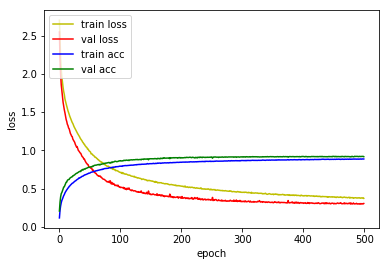

4815/4815 [==============================] - 1s 272us/sample - loss: 0.3302 - acc: 0.9070
Loss: 0.3301833349101145 Accuracy: 0.90695745

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6481 - acc: 0.1274
Epoch 00001: val_loss improved from inf to 2.33897, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_6_conv_checkpoint/001-2.3390.hdf5
36805/36805 [==============================] - 20s 550us/sample - loss: 2.6481 - acc: 0.1274 - val_loss: 2.3390 - val_acc: 0.2791
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2206 - acc: 0.2643
Epoch 00002: val_loss improved from 2.33897 to 1.90259, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_6_conv_checkpoint/002-1.9026.hdf5
36805/36805 [==============================] - 17s 467us/sample - loss: 2.2206 - acc: 0.2643 - val_loss: 1.9026 - val_acc: 0.3911
Epoch 3/500
36800/36805 [=========================

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9472 - acc: 0.7069
Epoch 00022: val_loss improved from 0.74294 to 0.70453, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_6_conv_checkpoint/022-0.7045.hdf5
36805/36805 [==============================] - 17s 463us/sample - loss: 0.9471 - acc: 0.7069 - val_loss: 0.7045 - val_acc: 0.8041
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9229 - acc: 0.7166
Epoch 00023: val_loss improved from 0.70453 to 0.67731, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_6_conv_checkpoint/023-0.6773.hdf5
36805/36805 [==============================] - 17s 466us/sample - loss: 0.9229 - acc: 0.7166 - val_loss: 0.6773 - val_acc: 0.8064
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9047 - acc: 0.7224
Epoch 00024: val_loss improved from 0.67731 to 0.65986, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_6_conv_ch

Epoch 45/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6149 - acc: 0.8140
Epoch 00045: val_loss improved from 0.41797 to 0.40005, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_6_conv_checkpoint/045-0.4001.hdf5
36805/36805 [==============================] - 17s 462us/sample - loss: 0.6149 - acc: 0.8140 - val_loss: 0.4001 - val_acc: 0.8926
Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6059 - acc: 0.8187
Epoch 00046: val_loss did not improve from 0.40005
36805/36805 [==============================] - 17s 461us/sample - loss: 0.6058 - acc: 0.8187 - val_loss: 0.4036 - val_acc: 0.8891
Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6022 - acc: 0.8163
Epoch 00047: val_loss improved from 0.40005 to 0.39828, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_6_conv_checkpoint/047-0.3983.hdf5
36805/36805 [==============================] - 17s 464us/sample - loss: 0.6021 - a

Epoch 69/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4744 - acc: 0.8589
Epoch 00069: val_loss did not improve from 0.30056
36805/36805 [==============================] - 17s 462us/sample - loss: 0.4744 - acc: 0.8590 - val_loss: 0.3128 - val_acc: 0.9152
Epoch 70/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4750 - acc: 0.8561
Epoch 00070: val_loss did not improve from 0.30056
36805/36805 [==============================] - 17s 465us/sample - loss: 0.4750 - acc: 0.8562 - val_loss: 0.3023 - val_acc: 0.9180
Epoch 71/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4703 - acc: 0.8593
Epoch 00071: val_loss improved from 0.30056 to 0.29572, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_6_conv_checkpoint/071-0.2957.hdf5
36805/36805 [==============================] - 17s 463us/sample - loss: 0.4704 - acc: 0.8593 - val_loss: 0.2957 - val_acc: 0.9210
Epoch 72/500
36800/36805 [============================>.] -

Epoch 95/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3997 - acc: 0.8786
Epoch 00095: val_loss improved from 0.25863 to 0.25816, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_6_conv_checkpoint/095-0.2582.hdf5
36805/36805 [==============================] - 17s 467us/sample - loss: 0.3997 - acc: 0.8786 - val_loss: 0.2582 - val_acc: 0.9294
Epoch 96/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3929 - acc: 0.8823
Epoch 00096: val_loss did not improve from 0.25816
36805/36805 [==============================] - 17s 465us/sample - loss: 0.3929 - acc: 0.8822 - val_loss: 0.2672 - val_acc: 0.9241
Epoch 97/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3935 - acc: 0.8800
Epoch 00097: val_loss improved from 0.25816 to 0.25792, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_6_conv_checkpoint/097-0.2579.hdf5
36805/36805 [==============================] - 17s 465us/sample - loss: 0.3934 - a

Epoch 120/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3525 - acc: 0.8927
Epoch 00120: val_loss did not improve from 0.22529
36805/36805 [==============================] - 17s 465us/sample - loss: 0.3524 - acc: 0.8928 - val_loss: 0.2273 - val_acc: 0.9364
Epoch 121/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3533 - acc: 0.8923
Epoch 00121: val_loss did not improve from 0.22529
36805/36805 [==============================] - 17s 461us/sample - loss: 0.3533 - acc: 0.8923 - val_loss: 0.2281 - val_acc: 0.9357
Epoch 122/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3502 - acc: 0.8932
Epoch 00122: val_loss did not improve from 0.22529
36805/36805 [==============================] - 17s 462us/sample - loss: 0.3501 - acc: 0.8932 - val_loss: 0.2284 - val_acc: 0.9369
Epoch 123/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3462 - acc: 0.8945
Epoch 00123: val_loss did not improve from 0.22529
36805/36805 [=

36736/36805 [============================>.] - ETA: 0s - loss: 0.3139 - acc: 0.9039
Epoch 00146: val_loss did not improve from 0.21195
36805/36805 [==============================] - 17s 464us/sample - loss: 0.3139 - acc: 0.9039 - val_loss: 0.2143 - val_acc: 0.9394
Epoch 147/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3144 - acc: 0.9034
Epoch 00147: val_loss improved from 0.21195 to 0.21105, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_6_conv_checkpoint/147-0.2110.hdf5
36805/36805 [==============================] - 17s 465us/sample - loss: 0.3143 - acc: 0.9034 - val_loss: 0.2110 - val_acc: 0.9387
Epoch 148/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3172 - acc: 0.9047
Epoch 00148: val_loss did not improve from 0.21105
36805/36805 [==============================] - 17s 465us/sample - loss: 0.3171 - acc: 0.9047 - val_loss: 0.2228 - val_acc: 0.9369
Epoch 149/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 173/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2970 - acc: 0.9087
Epoch 00173: val_loss did not improve from 0.20234
36805/36805 [==============================] - 17s 463us/sample - loss: 0.2970 - acc: 0.9087 - val_loss: 0.2083 - val_acc: 0.9390
Epoch 174/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2887 - acc: 0.9103
Epoch 00174: val_loss improved from 0.20234 to 0.20089, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_6_conv_checkpoint/174-0.2009.hdf5
36805/36805 [==============================] - 17s 464us/sample - loss: 0.2887 - acc: 0.9103 - val_loss: 0.2009 - val_acc: 0.9455
Epoch 175/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2853 - acc: 0.9119
Epoch 00175: val_loss did not improve from 0.20089
36805/36805 [==============================] - 17s 462us/sample - loss: 0.2853 - acc: 0.9119 - val_loss: 0.2026 - val_acc: 0.9464
Epoch 176/500
36800/36805 [============================>

36800/36805 [============================>.] - ETA: 0s - loss: 0.2654 - acc: 0.9183
Epoch 00201: val_loss did not improve from 0.19592
36805/36805 [==============================] - 17s 467us/sample - loss: 0.2654 - acc: 0.9182 - val_loss: 0.1970 - val_acc: 0.9471
Epoch 202/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2675 - acc: 0.9182
Epoch 00202: val_loss improved from 0.19592 to 0.19573, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_6_conv_checkpoint/202-0.1957.hdf5
36805/36805 [==============================] - 17s 470us/sample - loss: 0.2676 - acc: 0.9182 - val_loss: 0.1957 - val_acc: 0.9469
Epoch 203/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2661 - acc: 0.9169
Epoch 00203: val_loss improved from 0.19573 to 0.19354, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_6_conv_checkpoint/203-0.1935.hdf5
36805/36805 [==============================] - 17s 467us/sample - loss: 0.2660 - acc: 0.9169 

Epoch 229/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2467 - acc: 0.9229
Epoch 00229: val_loss did not improve from 0.18643
36805/36805 [==============================] - 17s 467us/sample - loss: 0.2467 - acc: 0.9228 - val_loss: 0.1972 - val_acc: 0.9469
Epoch 230/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2480 - acc: 0.9224
Epoch 00230: val_loss did not improve from 0.18643
36805/36805 [==============================] - 17s 468us/sample - loss: 0.2480 - acc: 0.9224 - val_loss: 0.1886 - val_acc: 0.9492
Epoch 231/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2439 - acc: 0.9244
Epoch 00231: val_loss did not improve from 0.18643
36805/36805 [==============================] - 17s 463us/sample - loss: 0.2439 - acc: 0.9244 - val_loss: 0.1918 - val_acc: 0.9464
Epoch 232/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2461 - acc: 0.9218
Epoch 00232: val_loss did not improve from 0.18643
36805/36805 [=

Epoch 259/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2296 - acc: 0.9267
Epoch 00259: val_loss did not improve from 0.18643
36805/36805 [==============================] - 17s 462us/sample - loss: 0.2297 - acc: 0.9267 - val_loss: 0.2104 - val_acc: 0.9464
Epoch 260/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2344 - acc: 0.9258
Epoch 00260: val_loss did not improve from 0.18643
36805/36805 [==============================] - 17s 463us/sample - loss: 0.2344 - acc: 0.9258 - val_loss: 0.1869 - val_acc: 0.9506
Epoch 261/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2311 - acc: 0.9281
Epoch 00261: val_loss did not improve from 0.18643
36805/36805 [==============================] - 17s 467us/sample - loss: 0.2311 - acc: 0.9281 - val_loss: 0.2020 - val_acc: 0.9481
Epoch 262/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2291 - acc: 0.9283
Epoch 00262: val_loss improved from 0.18643 to 0.18354, saving mo

Epoch 288/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2145 - acc: 0.9310
Epoch 00288: val_loss did not improve from 0.18354
36805/36805 [==============================] - 17s 464us/sample - loss: 0.2145 - acc: 0.9309 - val_loss: 0.1925 - val_acc: 0.9488
Epoch 289/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2138 - acc: 0.9324
Epoch 00289: val_loss improved from 0.18354 to 0.18247, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_6_conv_checkpoint/289-0.1825.hdf5
36805/36805 [==============================] - 17s 466us/sample - loss: 0.2138 - acc: 0.9324 - val_loss: 0.1825 - val_acc: 0.9495
Epoch 290/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2140 - acc: 0.9313
Epoch 00290: val_loss did not improve from 0.18247
36805/36805 [==============================] - 17s 465us/sample - loss: 0.2140 - acc: 0.9313 - val_loss: 0.1952 - val_acc: 0.9502
Epoch 291/500
36800/36805 [============================>

Epoch 317/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2060 - acc: 0.9333
Epoch 00317: val_loss did not improve from 0.18243
36805/36805 [==============================] - 17s 462us/sample - loss: 0.2059 - acc: 0.9334 - val_loss: 0.1911 - val_acc: 0.9488
Epoch 318/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2044 - acc: 0.9340
Epoch 00318: val_loss did not improve from 0.18243
36805/36805 [==============================] - 17s 463us/sample - loss: 0.2044 - acc: 0.9340 - val_loss: 0.1869 - val_acc: 0.9534
Epoch 319/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2064 - acc: 0.9337
Epoch 00319: val_loss did not improve from 0.18243
36805/36805 [==============================] - 17s 464us/sample - loss: 0.2064 - acc: 0.9338 - val_loss: 0.1896 - val_acc: 0.9509
Epoch 320/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2045 - acc: 0.9348
Epoch 00320: val_loss did not improve from 0.18243
36805/36805 [=

Epoch 347/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1913 - acc: 0.9376
Epoch 00347: val_loss did not improve from 0.18243
36805/36805 [==============================] - 17s 463us/sample - loss: 0.1913 - acc: 0.9376 - val_loss: 0.1913 - val_acc: 0.9518
Epoch 348/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1887 - acc: 0.9392
Epoch 00348: val_loss did not improve from 0.18243
36805/36805 [==============================] - 17s 463us/sample - loss: 0.1888 - acc: 0.9391 - val_loss: 0.1985 - val_acc: 0.9481
Epoch 349/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1915 - acc: 0.9383
Epoch 00349: val_loss did not improve from 0.18243
36805/36805 [==============================] - 17s 468us/sample - loss: 0.1915 - acc: 0.9383 - val_loss: 0.1856 - val_acc: 0.9520
Epoch 350/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1949 - acc: 0.9369
Epoch 00350: val_loss did not improve from 0.18243
36805/36805 [=

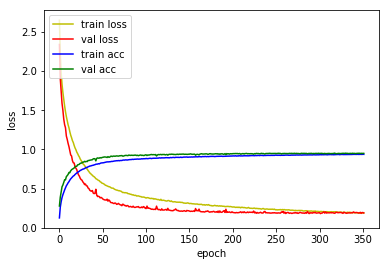

4815/4815 [==============================] - 1s 282us/sample - loss: 0.2143 - acc: 0.9348
Loss: 0.2142969814663983 Accuracy: 0.9347871

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5586 - acc: 0.1563
Epoch 00001: val_loss improved from inf to 2.02206, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_7_conv_checkpoint/001-2.0221.hdf5
36805/36805 [==============================] - 21s 578us/sample - loss: 2.5585 - acc: 0.1563 - val_loss: 2.0221 - val_acc: 0.4062
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9279 - acc: 0.3629
Epoch 00002: val_loss improved from 2.02206 to 1.53185, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_7_conv_checkpoint/002-1.5319.hdf5
36805/36805 [==============================] - 18s 489us/sample - loss: 1.9280 - acc: 0.3629 - val_loss: 1.5319 - val_acc: 0.5691
Epoch 3/500
36800/36805 [==========================

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5754 - acc: 0.8225
Epoch 00022: val_loss improved from 0.39709 to 0.38233, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_7_conv_checkpoint/022-0.3823.hdf5
36805/36805 [==============================] - 18s 487us/sample - loss: 0.5754 - acc: 0.8225 - val_loss: 0.3823 - val_acc: 0.8894
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5550 - acc: 0.8290
Epoch 00023: val_loss did not improve from 0.38233
36805/36805 [==============================] - 18s 484us/sample - loss: 0.5550 - acc: 0.8290 - val_loss: 0.3840 - val_acc: 0.8898
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5444 - acc: 0.8339
Epoch 00024: val_loss improved from 0.38233 to 0.35769, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_7_conv_checkpoint/024-0.3577.hdf5
36805/36805 [==============================] - 18s 486us/sample - loss: 0.5443 - a

Epoch 45/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3528 - acc: 0.8922
Epoch 00045: val_loss did not improve from 0.23423
36805/36805 [==============================] - 18s 490us/sample - loss: 0.3528 - acc: 0.8922 - val_loss: 0.2373 - val_acc: 0.9278
Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3463 - acc: 0.8948
Epoch 00046: val_loss improved from 0.23423 to 0.22577, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_7_conv_checkpoint/046-0.2258.hdf5
36805/36805 [==============================] - 18s 490us/sample - loss: 0.3463 - acc: 0.8948 - val_loss: 0.2258 - val_acc: 0.9336
Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3394 - acc: 0.8953
Epoch 00047: val_loss did not improve from 0.22577
36805/36805 [==============================] - 18s 486us/sample - loss: 0.3394 - acc: 0.8953 - val_loss: 0.2270 - val_acc: 0.9366
Epoch 48/500
36800/36805 [============================>.] -

Epoch 71/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2542 - acc: 0.9218
Epoch 00071: val_loss did not improve from 0.17394
36805/36805 [==============================] - 18s 487us/sample - loss: 0.2542 - acc: 0.9218 - val_loss: 0.1821 - val_acc: 0.9429
Epoch 72/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2553 - acc: 0.9202
Epoch 00072: val_loss did not improve from 0.17394
36805/36805 [==============================] - 18s 485us/sample - loss: 0.2553 - acc: 0.9202 - val_loss: 0.1790 - val_acc: 0.9485
Epoch 73/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2482 - acc: 0.9226
Epoch 00073: val_loss did not improve from 0.17394
36805/36805 [==============================] - 18s 486us/sample - loss: 0.2482 - acc: 0.9226 - val_loss: 0.1755 - val_acc: 0.9469
Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2478 - acc: 0.9226
Epoch 00074: val_loss improved from 0.17394 to 0.17316, saving model 

Epoch 98/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2020 - acc: 0.9353
Epoch 00098: val_loss did not improve from 0.14910
36805/36805 [==============================] - 18s 486us/sample - loss: 0.2019 - acc: 0.9353 - val_loss: 0.1496 - val_acc: 0.9557
Epoch 99/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1983 - acc: 0.9377
Epoch 00099: val_loss improved from 0.14910 to 0.14694, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_7_conv_checkpoint/099-0.1469.hdf5
36805/36805 [==============================] - 18s 492us/sample - loss: 0.1983 - acc: 0.9378 - val_loss: 0.1469 - val_acc: 0.9555
Epoch 100/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2006 - acc: 0.9384
Epoch 00100: val_loss did not improve from 0.14694
36805/36805 [==============================] - 18s 487us/sample - loss: 0.2006 - acc: 0.9384 - val_loss: 0.1525 - val_acc: 0.9539
Epoch 101/500
36800/36805 [============================>.]

36800/36805 [============================>.] - ETA: 0s - loss: 0.1678 - acc: 0.9462
Epoch 00125: val_loss did not improve from 0.13549
36805/36805 [==============================] - 18s 483us/sample - loss: 0.1678 - acc: 0.9462 - val_loss: 0.1408 - val_acc: 0.9602
Epoch 126/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1668 - acc: 0.9460
Epoch 00126: val_loss did not improve from 0.13549
36805/36805 [==============================] - 18s 486us/sample - loss: 0.1669 - acc: 0.9460 - val_loss: 0.1401 - val_acc: 0.9583
Epoch 127/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1658 - acc: 0.9476
Epoch 00127: val_loss did not improve from 0.13549
36805/36805 [==============================] - 18s 488us/sample - loss: 0.1658 - acc: 0.9476 - val_loss: 0.1409 - val_acc: 0.9581
Epoch 128/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1607 - acc: 0.9478
Epoch 00128: val_loss did not improve from 0.13549
36805/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 0.1394 - acc: 0.9537
Epoch 00154: val_loss did not improve from 0.13248
36805/36805 [==============================] - 18s 485us/sample - loss: 0.1394 - acc: 0.9537 - val_loss: 0.1333 - val_acc: 0.9590
Epoch 155/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1376 - acc: 0.9556
Epoch 00155: val_loss did not improve from 0.13248
36805/36805 [==============================] - 18s 484us/sample - loss: 0.1376 - acc: 0.9556 - val_loss: 0.1405 - val_acc: 0.9571
Epoch 156/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1437 - acc: 0.9527
Epoch 00156: val_loss did not improve from 0.13248
36805/36805 [==============================] - 18s 488us/sample - loss: 0.1436 - acc: 0.9527 - val_loss: 0.1539 - val_acc: 0.9574
Epoch 157/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1394 - acc: 0.9548
Epoch 00157: val_loss did not improve from 0.13248
36805/36805 [===============

Epoch 184/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1230 - acc: 0.9590
Epoch 00184: val_loss improved from 0.13248 to 0.13187, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_7_conv_checkpoint/184-0.1319.hdf5
36805/36805 [==============================] - 18s 489us/sample - loss: 0.1230 - acc: 0.9590 - val_loss: 0.1319 - val_acc: 0.9620
Epoch 185/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1163 - acc: 0.9612
Epoch 00185: val_loss did not improve from 0.13187
36805/36805 [==============================] - 18s 487us/sample - loss: 0.1163 - acc: 0.9611 - val_loss: 0.1391 - val_acc: 0.9585
Epoch 186/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1168 - acc: 0.9613
Epoch 00186: val_loss did not improve from 0.13187
36805/36805 [==============================] - 18s 484us/sample - loss: 0.1168 - acc: 0.9613 - val_loss: 0.1372 - val_acc: 0.9609
Epoch 187/500
36800/36805 [============================>

36800/36805 [============================>.] - ETA: 0s - loss: 0.1040 - acc: 0.9654
Epoch 00212: val_loss did not improve from 0.12918
36805/36805 [==============================] - 18s 483us/sample - loss: 0.1040 - acc: 0.9654 - val_loss: 0.1372 - val_acc: 0.9620
Epoch 213/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1049 - acc: 0.9639
Epoch 00213: val_loss did not improve from 0.12918
36805/36805 [==============================] - 18s 484us/sample - loss: 0.1049 - acc: 0.9639 - val_loss: 0.1464 - val_acc: 0.9583
Epoch 214/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1037 - acc: 0.9640
Epoch 00214: val_loss did not improve from 0.12918
36805/36805 [==============================] - 18s 482us/sample - loss: 0.1036 - acc: 0.9640 - val_loss: 0.1505 - val_acc: 0.9597
Epoch 215/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1039 - acc: 0.9647
Epoch 00215: val_loss did not improve from 0.12918
36805/36805 [===============

Epoch 242/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0945 - acc: 0.9690
Epoch 00242: val_loss did not improve from 0.12918
36805/36805 [==============================] - 18s 498us/sample - loss: 0.0945 - acc: 0.9690 - val_loss: 0.1420 - val_acc: 0.9609
Epoch 243/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0885 - acc: 0.9706
Epoch 00243: val_loss did not improve from 0.12918
36805/36805 [==============================] - 18s 496us/sample - loss: 0.0885 - acc: 0.9706 - val_loss: 0.1398 - val_acc: 0.9639
Epoch 244/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0910 - acc: 0.9698
Epoch 00244: val_loss did not improve from 0.12918
36805/36805 [==============================] - 18s 498us/sample - loss: 0.0910 - acc: 0.9698 - val_loss: 0.1505 - val_acc: 0.9634
Epoch 245/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0887 - acc: 0.9701
Epoch 00245: val_loss did not improve from 0.12918
36805/36805 [=

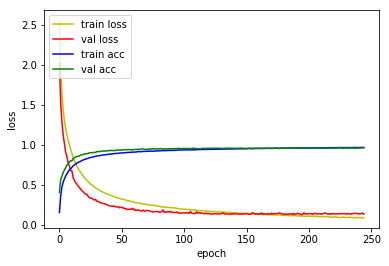

4815/4815 [==============================] - 1s 311us/sample - loss: 0.1930 - acc: 0.9487
Loss: 0.1930468858464361 Accuracy: 0.948702

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5925 - acc: 0.1475
Epoch 00001: val_loss improved from inf to 2.20051, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_8_conv_checkpoint/001-2.2005.hdf5
36805/36805 [==============================] - 23s 634us/sample - loss: 2.5924 - acc: 0.1475 - val_loss: 2.2005 - val_acc: 0.3287
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9276 - acc: 0.3776
Epoch 00002: val_loss improved from 2.20051 to 1.30297, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_8_conv_checkpoint/002-1.3030.hdf5
36805/36805 [==============================] - 19s 513us/sample - loss: 1.9275 - acc: 0.3776 - val_loss: 1.3030 - val_acc: 0.6077
Epoch 3/500
36800/36805 [===========================

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3793 - acc: 0.8815
Epoch 00022: val_loss improved from 0.26329 to 0.25572, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_8_conv_checkpoint/022-0.2557.hdf5
36805/36805 [==============================] - 19s 520us/sample - loss: 0.3793 - acc: 0.8816 - val_loss: 0.2557 - val_acc: 0.9238
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3649 - acc: 0.8851
Epoch 00023: val_loss improved from 0.25572 to 0.25233, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_8_conv_checkpoint/023-0.2523.hdf5
36805/36805 [==============================] - 19s 520us/sample - loss: 0.3648 - acc: 0.8851 - val_loss: 0.2523 - val_acc: 0.9220
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3520 - acc: 0.8902
Epoch 00024: val_loss improved from 0.25233 to 0.23129, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_8_conv_ch

Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2072 - acc: 0.9347
Epoch 00046: val_loss improved from 0.17090 to 0.16895, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_ch_32_DO_8_conv_checkpoint/046-0.1690.hdf5
36805/36805 [==============================] - 19s 514us/sample - loss: 0.2072 - acc: 0.9347 - val_loss: 0.1690 - val_acc: 0.9471
Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2051 - acc: 0.9355
Epoch 00047: val_loss did not improve from 0.16895
36805/36805 [==============================] - 19s 519us/sample - loss: 0.2052 - acc: 0.9354 - val_loss: 0.1834 - val_acc: 0.9453
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2048 - acc: 0.9340
Epoch 00048: val_loss did not improve from 0.16895
36805/36805 [==============================] - 19s 515us/sample - loss: 0.2047 - acc: 0.9341 - val_loss: 0.1761 - val_acc: 0.9448
Epoch 49/500
36800/36805 [============================>.] -

Epoch 73/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1373 - acc: 0.9551
Epoch 00073: val_loss did not improve from 0.14788
36805/36805 [==============================] - 19s 516us/sample - loss: 0.1373 - acc: 0.9551 - val_loss: 0.1594 - val_acc: 0.9555
Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1327 - acc: 0.9557
Epoch 00074: val_loss did not improve from 0.14788
36805/36805 [==============================] - 20s 537us/sample - loss: 0.1327 - acc: 0.9557 - val_loss: 0.1532 - val_acc: 0.9543
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1363 - acc: 0.9544
Epoch 00075: val_loss did not improve from 0.14788
36805/36805 [==============================] - 19s 516us/sample - loss: 0.1363 - acc: 0.9544 - val_loss: 0.1549 - val_acc: 0.9546
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1319 - acc: 0.9564
Epoch 00076: val_loss did not improve from 0.14788
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.0967 - acc: 0.9675
Epoch 00102: val_loss did not improve from 0.14619
36805/36805 [==============================] - 19s 504us/sample - loss: 0.0967 - acc: 0.9675 - val_loss: 0.1644 - val_acc: 0.9527
Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0957 - acc: 0.9672
Epoch 00103: val_loss did not improve from 0.14619
36805/36805 [==============================] - 19s 507us/sample - loss: 0.0957 - acc: 0.9672 - val_loss: 0.1513 - val_acc: 0.9592
Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0901 - acc: 0.9694
Epoch 00104: val_loss did not improve from 0.14619
36805/36805 [==============================] - 19s 506us/sample - loss: 0.0901 - acc: 0.9694 - val_loss: 0.1554 - val_acc: 0.9574
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0956 - acc: 0.9676
Epoch 00105: val_loss did not improve from 0.14619
36805/36805 [===============

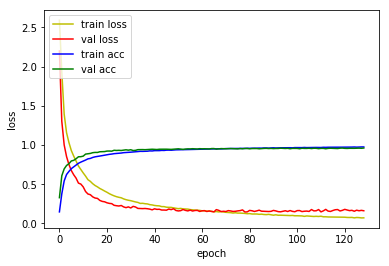

4815/4815 [==============================] - 2s 339us/sample - loss: 0.2102 - acc: 0.9344
Loss: 0.21017240282778676 Accuracy: 0.93437177



In [10]:
base = '1D_CNN_custom_multi_3_GAP_ch_32_DO'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_3_GAP_ch_32_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 32)     0           activation_33[0][0]              
____________________________________________________________

4815/4815 [==============================] - 2s 314us/sample - loss: 0.6589 - acc: 0.8064
Loss: 0.6589304419445224 Accuracy: 0.8064382

1D_CNN_custom_multi_3_GAP_ch_32_DO_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 16000, 32)    0           conv1d_40[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_40 (MaxPoo

4815/4815 [==============================] - 2s 338us/sample - loss: 0.2143 - acc: 0.9348
Loss: 0.2142969814663983 Accuracy: 0.9347871

1D_CNN_custom_multi_3_GAP_ch_32_DO_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
activation_51 (Activation)      (None, 16000, 32)    0           conv1d_51[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_51 (MaxPoo

4815/4815 [==============================] - 2s 348us/sample - loss: 0.2102 - acc: 0.9344
Loss: 0.21017240282778676 Accuracy: 0.93437177


In [12]:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_3_GAP_ch_32_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 32)     0           activation_33[0][0]              
____________________________________________________________

4815/4815 [==============================] - 2s 354us/sample - loss: 0.6640 - acc: 0.8027
Loss: 0.663954120954868 Accuracy: 0.8026999

1D_CNN_custom_multi_3_GAP_ch_32_DO_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 16000, 32)    0           conv1d_40[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_40 (MaxPool

4815/4815 [==============================] - 2s 404us/sample - loss: 0.2177 - acc: 0.9342
Loss: 0.21774046612924752 Accuracy: 0.93416405

1D_CNN_custom_multi_3_GAP_ch_32_DO_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
activation_51 (Activation)      (None, 16000, 32)    0           conv1d_51[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_51 (MaxP

4815/4815 [==============================] - 2s 418us/sample - loss: 0.2493 - acc: 0.9389
Loss: 0.24930718194379986 Accuracy: 0.9389408
